In [36]:
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from sklearn import metrics
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from xgboost import plot_importance
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV



In [2]:
def confusion_matrix(model, x,y):

    plot_confusion_matrix(model, x, y,cmap=plt.cm.Blues)  
    
def roc_auc_curve(y_gt,y_pred,model_name, color):
    fpr, tpr, _ = metrics.roc_curve(y_gt,  y_pred)
    auc = metrics.roc_auc_score(y_gt, y_pred)
    plt.plot(fpr,tpr,linestyle='--',color=color)
    plt.title(label=model_name + ", auc="+str(auc))
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()
    return fpr, tpr, auc
    
def plot_roc(models):
    for key, value in models.items():
        sns.lineplot(x=value[0], y=value[1], label=key+"_"+str(value[2]))

    ax = sns.lineplot(x=[0, 0.5, 1], y=[0, 0.5, 1])
    ax.lines[len(models)].set_linestyle("--")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve')

model_metrics={"Model_name":[],
        "FPR":[],
        "TPR":[],
        "Accuracy":[],
        "AUC Score":[]
      }

In [3]:
df = pd.read_csv("./data/transaction_df.csv", index_col=0)
print("Shape of DF", df.shape)
print("Fraud Count", df["isFraud"].value_counts())
print("Columns = ",df.columns)
print("Type of values in columns")
print(df.dtypes)

Shape of DF (786363, 29)
Fraud Count False    773946
True      12417
Name: isFraud, dtype: int64
Columns =  Index(['accountNumber', 'customerId', 'creditLimit', 'availableMoney',
       'transactionDateTime', 'transactionAmount', 'merchantName',
       'acqCountry', 'merchantCountryCode', 'posEntryMode', 'posConditionCode',
       'merchantCategoryCode', 'currentExpDate', 'accountOpenDate',
       'dateOfLastAddressChange', 'cardCVV', 'enteredCVV', 'cardLast4Digits',
       'transactionType', 'echoBuffer', 'currentBalance', 'merchantCity',
       'merchantState', 'merchantZip', 'cardPresent', 'posOnPremises',
       'recurringAuthInd', 'expirationDateKeyInMatch', 'isFraud'],
      dtype='object')
Type of values in columns
accountNumber                 int64
customerId                    int64
creditLimit                   int64
availableMoney              float64
transactionDateTime          object
transactionAmount           float64
merchantName                 object
acqCountry      

In [4]:
df.isnull().sum()

accountNumber                    0
customerId                       0
creditLimit                      0
availableMoney                   0
transactionDateTime              0
transactionAmount                0
merchantName                     0
acqCountry                    4562
merchantCountryCode            724
posEntryMode                  4054
posConditionCode               409
merchantCategoryCode             0
currentExpDate                   0
accountOpenDate                  0
dateOfLastAddressChange          0
cardCVV                          0
enteredCVV                       0
cardLast4Digits                  0
transactionType                698
echoBuffer                  786363
currentBalance                   0
merchantCity                786363
merchantState               786363
merchantZip                 786363
cardPresent                      0
posOnPremises               786363
recurringAuthInd            786363
expirationDateKeyInMatch         0
isFraud             

Removing Columns that have no value and date
I want to work on date if I have time like see if there is a pattern between date and fraud like most frauds are committed at night or afternoon based on location

In [5]:
df_ml = df.drop(['accountNumber','customerId','echoBuffer','cardLast4Digits','merchantName','accountOpenDate','transactionDateTime','currentExpDate','dateOfLastAddressChange','merchantCity','merchantState','merchantZip','recurringAuthInd','posOnPremises'],axis =1)


Because machine learning algorithms assume (and require) your data to be numeric, categorical data must be pre-processed in order for it to be accepted.

In [6]:
df_ml['matchingCVV'] = df_ml['cardCVV'] == df_ml['enteredCVV']
print(df_ml['matchingCVV'].value_counts())
print(df_ml[df_ml['matchingCVV']==False]["isFraud"].value_counts())

df_ml.drop(['enteredCVV','cardCVV'],axis=1, inplace=True)
print(df_ml.columns)

True     779348
False      7015
Name: matchingCVV, dtype: int64
False    6812
True      203
Name: isFraud, dtype: int64
Index(['creditLimit', 'availableMoney', 'transactionAmount', 'acqCountry',
       'merchantCountryCode', 'posEntryMode', 'posConditionCode',
       'merchantCategoryCode', 'transactionType', 'currentBalance',
       'cardPresent', 'expirationDateKeyInMatch', 'isFraud', 'matchingCVV'],
      dtype='object')


In [7]:
print(df_ml.dtypes)
print(df_ml.isnull().sum())
df_drop = df_ml.dropna()
print("Total NaN", len(df)-len(df_drop))
print("% drop", ((len(df)-len(df_drop))*100)/len(df))

creditLimit                   int64
availableMoney              float64
transactionAmount           float64
acqCountry                   object
merchantCountryCode          object
posEntryMode                float64
posConditionCode            float64
merchantCategoryCode         object
transactionType              object
currentBalance              float64
cardPresent                    bool
expirationDateKeyInMatch       bool
isFraud                        bool
matchingCVV                    bool
dtype: object
creditLimit                    0
availableMoney                 0
transactionAmount              0
acqCountry                  4562
merchantCountryCode          724
posEntryMode                4054
posConditionCode             409
merchantCategoryCode           0
transactionType              698
currentBalance                 0
cardPresent                    0
expirationDateKeyInMatch       0
isFraud                        0
matchingCVV                    0
dtype: int64
Total N

For NaN:
- You can either drop Na or
- Impute it by mean or any constant value

I dropped it as it is just 1.2% 

In [8]:
df_ml = df_drop

For Logistic Regression and other Classification problems,
We'll need to assume couple of things and check if that is true or not


Assumption #1: There is No Multicollinearity Among Explanatory Variables

Assumption #2: The Observations are Independent

Assumption #3: The Response Variable is Binary

Assumption #4: The Sample Size is Sufficiently Large

Assumption #5: There are No Extreme Outliers

#### Assumption #1: There is No Multicollinearity Among Explanatory Variables
#### Assumption #2: The Observations are Independent

In [9]:
display(df_ml.corr(method = 'pearson'))

,creditLimit,availableMoney,transactionAmount,posEntryMode,posConditionCode,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,matchingCVV
creditLimit,1.000000,0.834845,0.005721,-0.000823,-0.000144,0.654006,-0.003874,0.002353,0.003423,0.001124
availableMoney,0.834845,1.000000,-0.009897,-0.000456,0.000538,0.129558,0.002400,0.004229,-0.001377,-0.000698
transactionAmount,0.005721,-0.009897,1.000000,0.003104,-0.000417,0.023906,0.037346,0.001931,0.074359,0.000740
posEntryMode,-0.000823,-0.000456,0.003104,1.000000,-0.000685,-0.000856,-0.001144,0.001576,0.007888,0.000586
posConditionCode,-0.000144,0.000538,-0.000417,-0.000685,1.000000,-0.000999,0.001538,-0.000776,0.008135,-0.000580
currentBalance,0.654006,0.129558,0.023906,-0.000856,-0.000999,1.000000,-0.010277,-0.001573,0.008059,0.002983
cardPresent,-0.003874,0.002400,0.037346,-0.001144,0.001538,-0.010277,1.000000,0.040312,-0.042761,0.003156
expirationDateKeyInMatch,0.002353,0.004229,0.001931,0.001576,-0.000776,-0.001573,0.040312,1.000000,-0.000808,0.000058
isFraud,0.003423,-0.001377,0.074359,0.007888,0.008135,0.008059,-0.042761,-0.000808,1.000000,-0.010142
matchingCVV,0.001124,-0.000698,0.000740,0.000586,-0.000580,0.002983,0.003156,0.000058,-0.010142,1.000000


Text(0, 0.5, 'availableMoney')

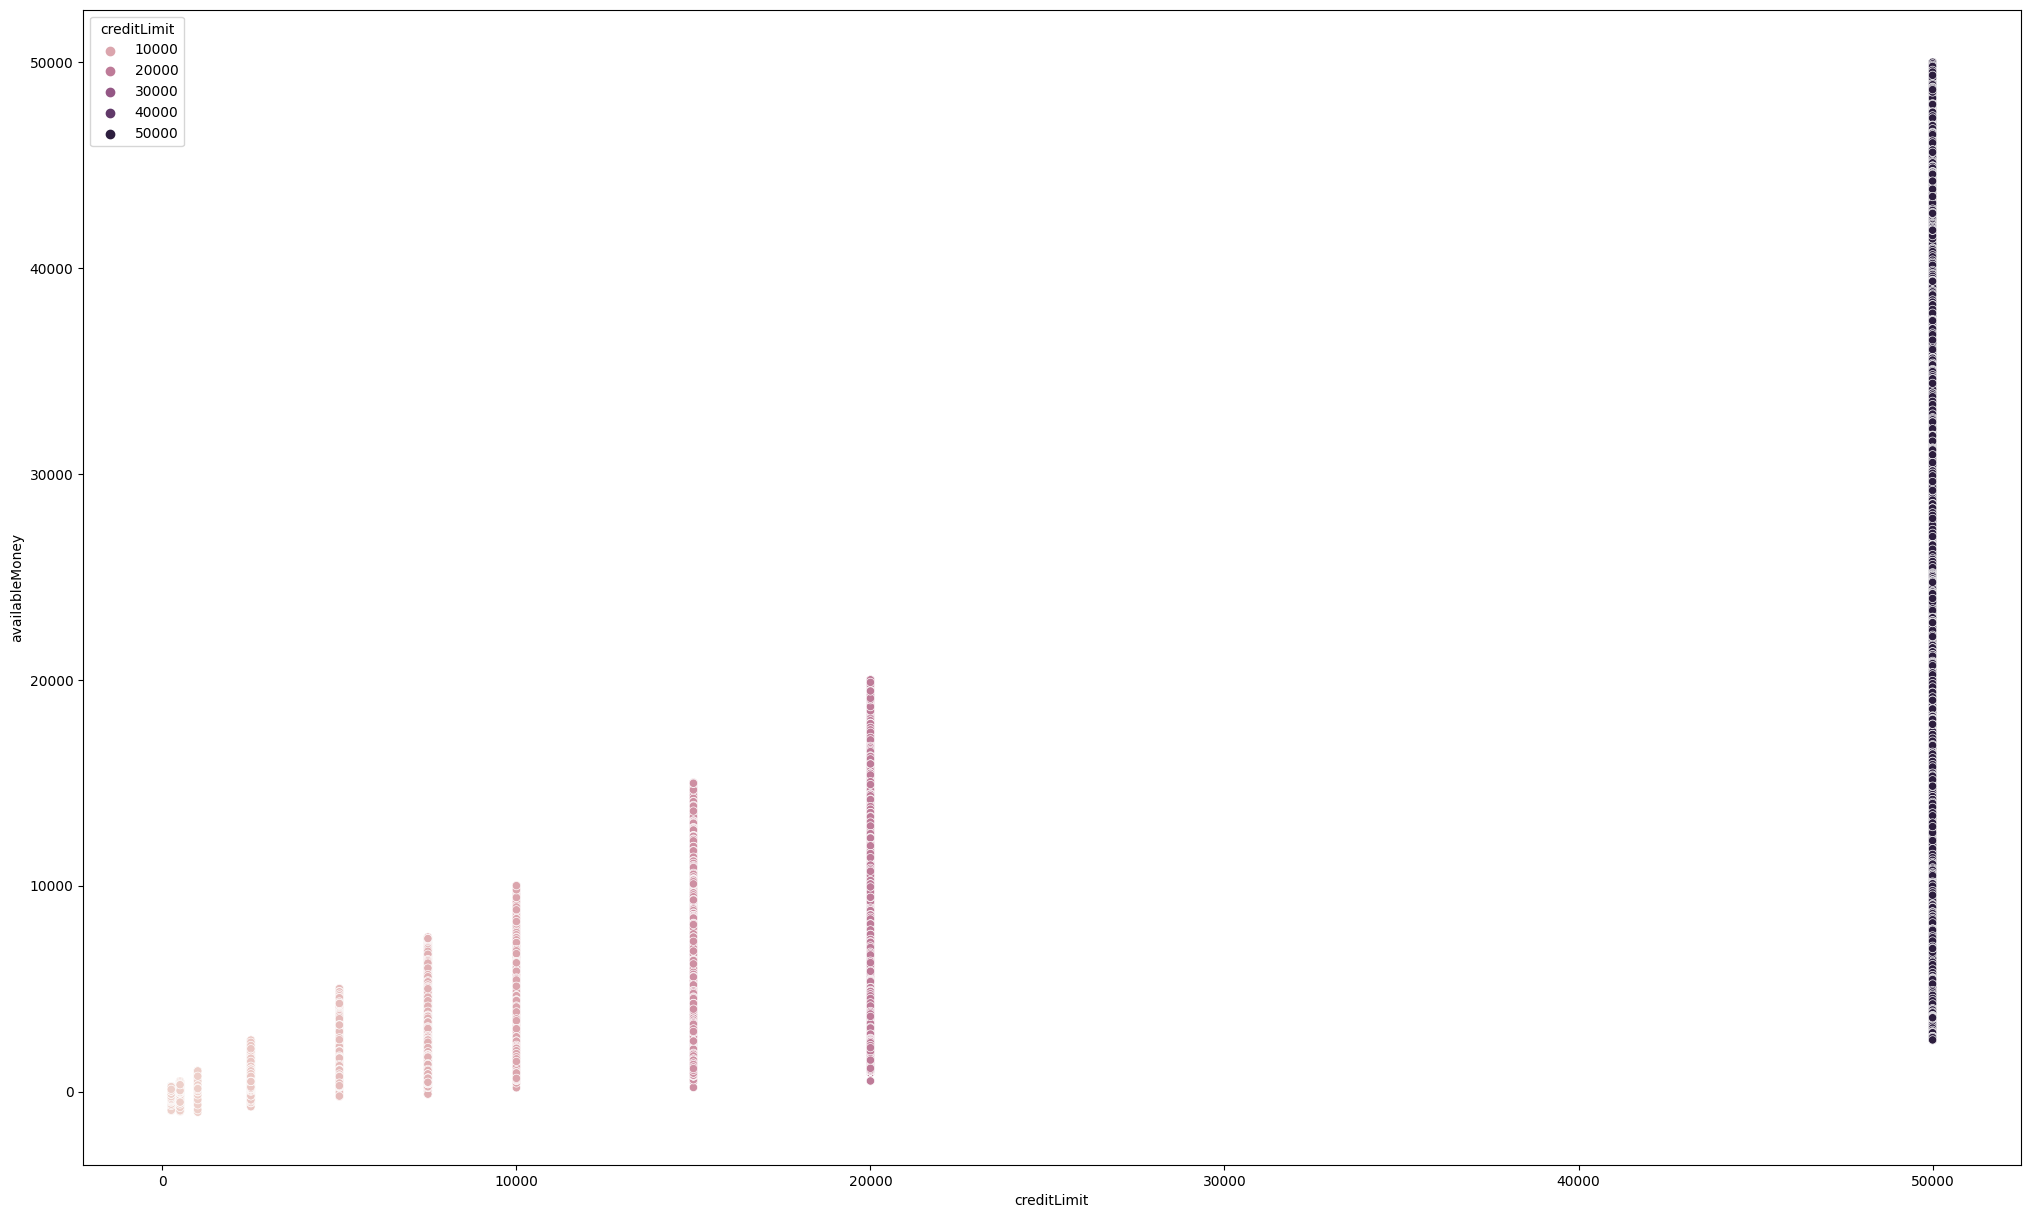

In [10]:
plt.figure(figsize=(25,15))
sns.scatterplot(data=df_ml, x='creditLimit', y='availableMoney', hue='creditLimit')
plt.xlabel('creditLimit')
plt.ylabel('availableMoney')

There is strong correlation between these two above column of 0.834845

Text(0, 0.5, 'currentBalance')

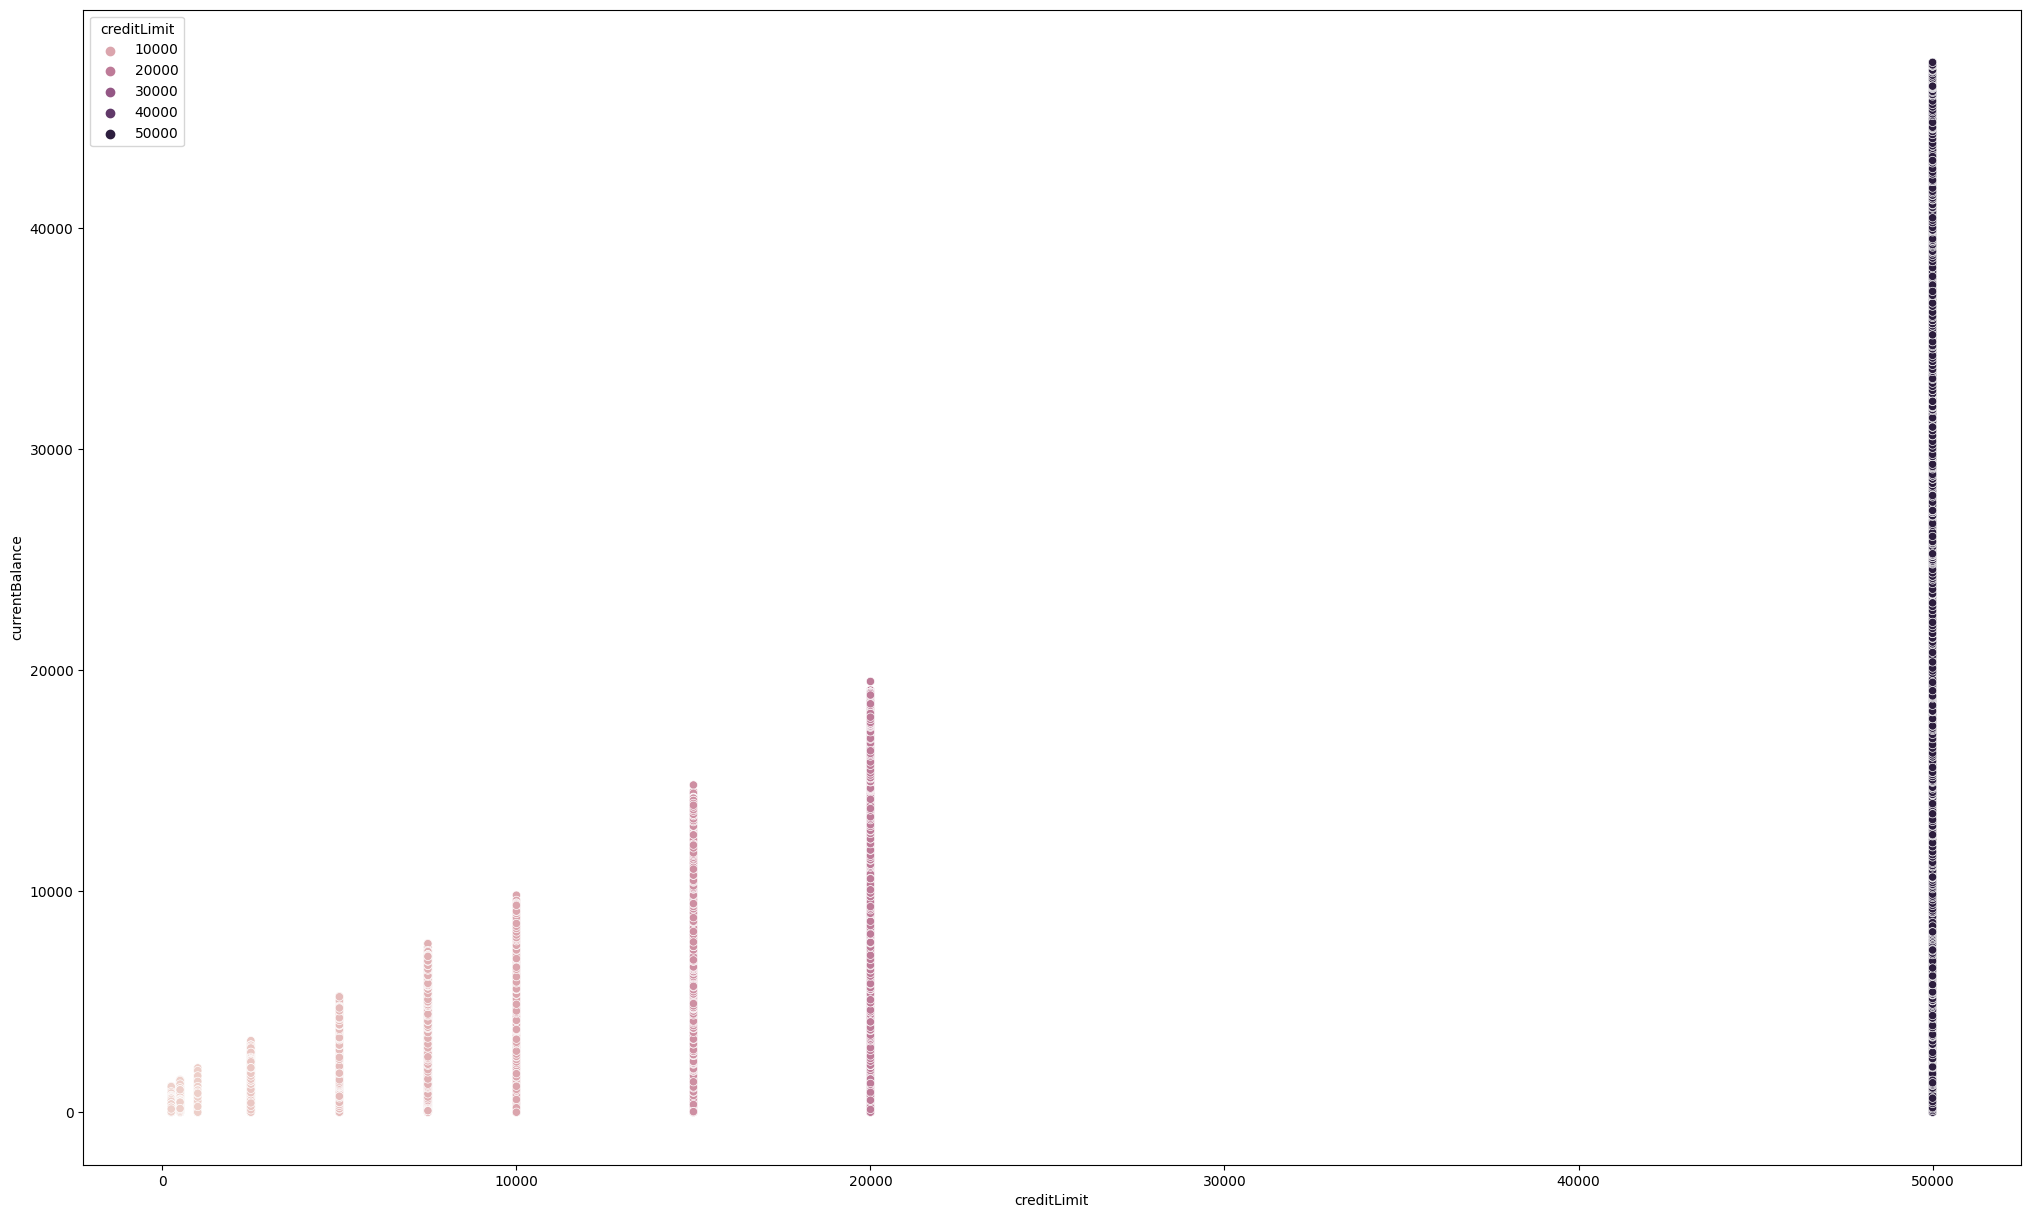

In [11]:
plt.figure(figsize=(25,15))
sns.scatterplot(data=df_ml, x='creditLimit', y='currentBalance', hue='creditLimit')
plt.xlabel('creditLimit')
plt.ylabel('currentBalance')

There is strong correlation between these two above columns of 0.654006	

Text(0, 0.5, 'transactionAmount')

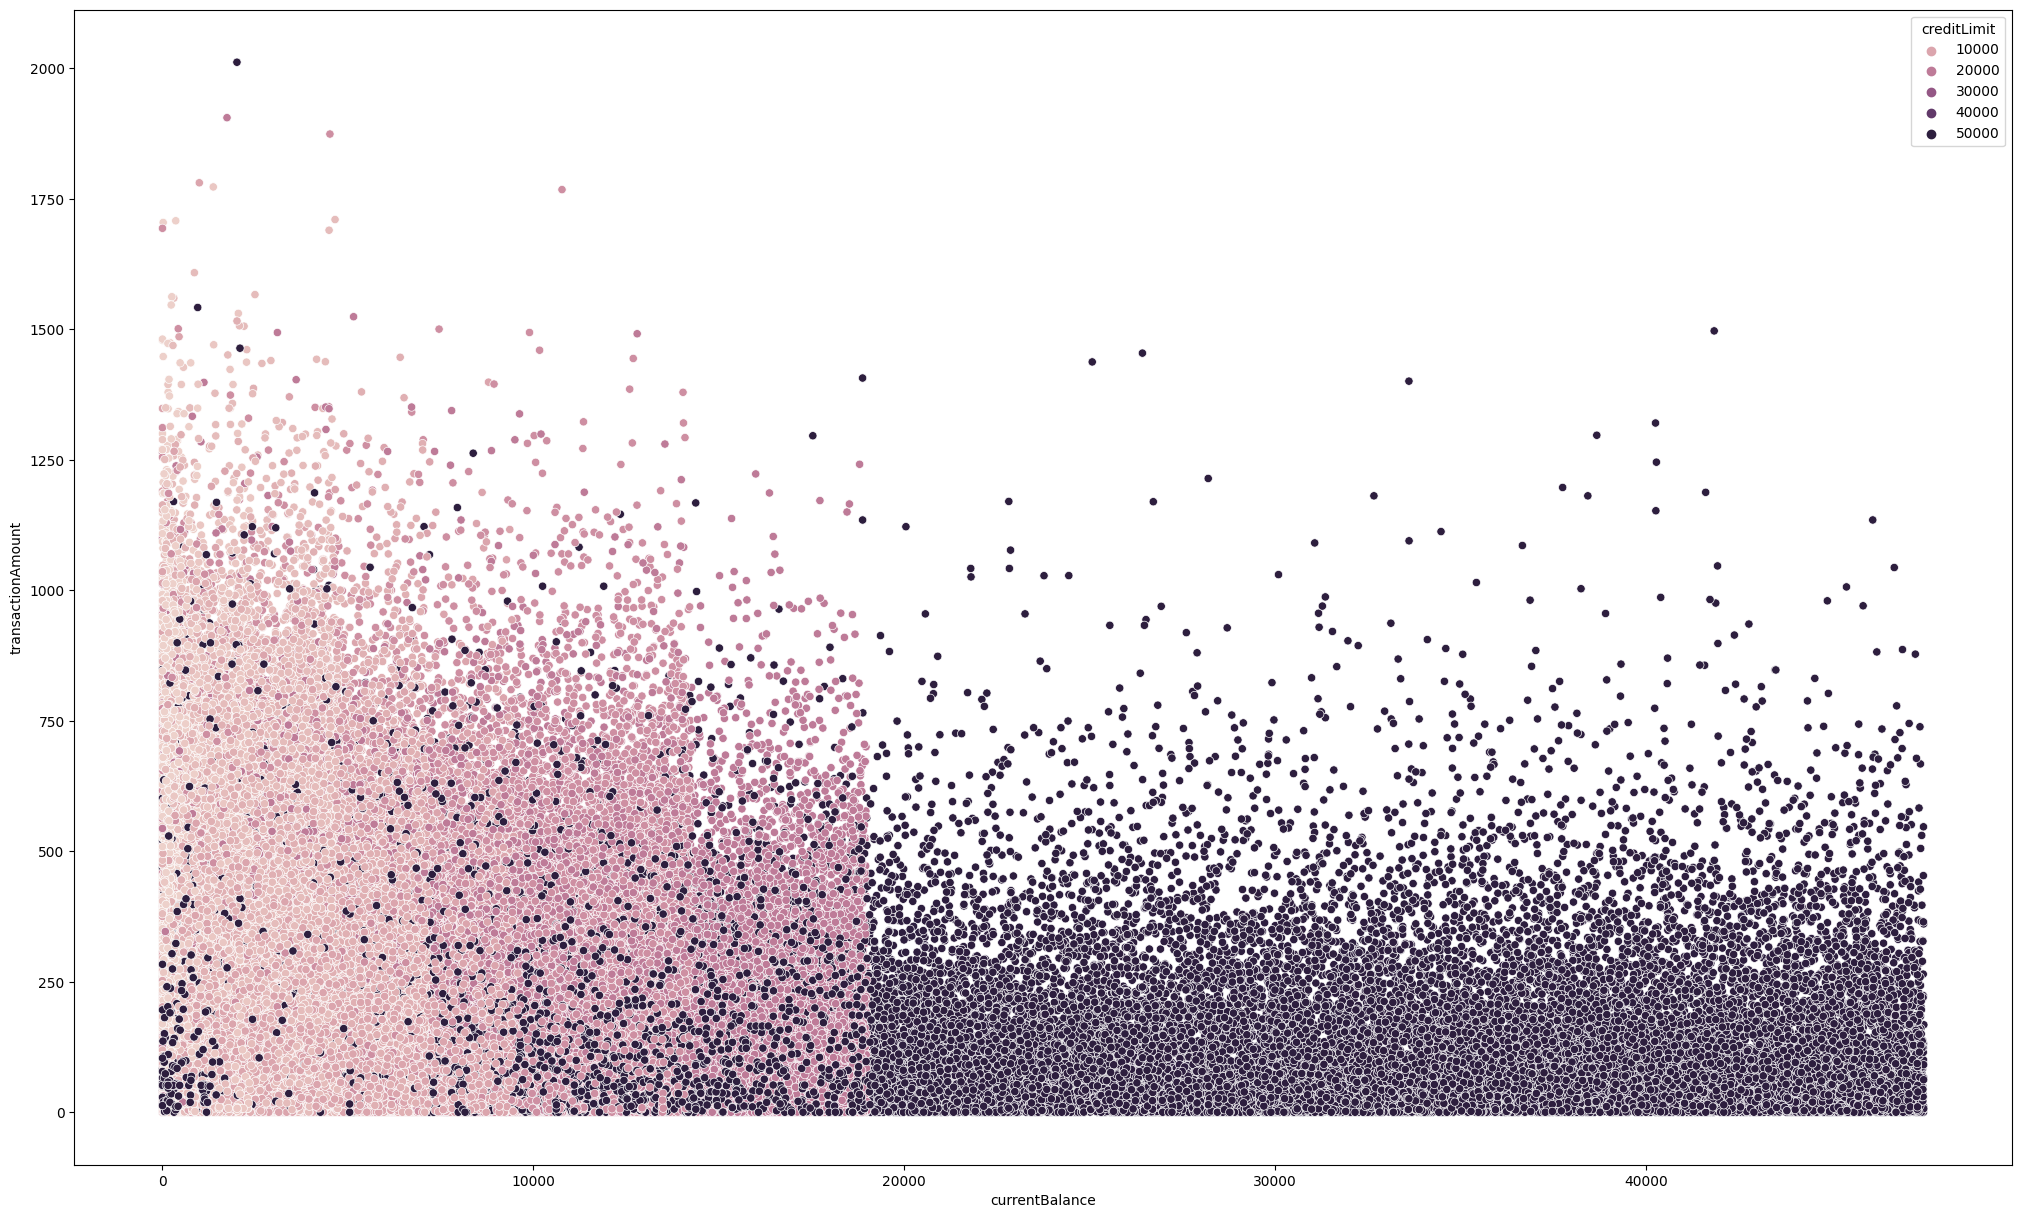

In [12]:
plt.figure(figsize=(25,15))
sns.scatterplot(data=df_ml, x='currentBalance', y='transactionAmount', hue='creditLimit')
plt.xlabel('currentBalance')
plt.ylabel('transactionAmount')

<AxesSubplot:xlabel='posConditionCode', ylabel='count'>

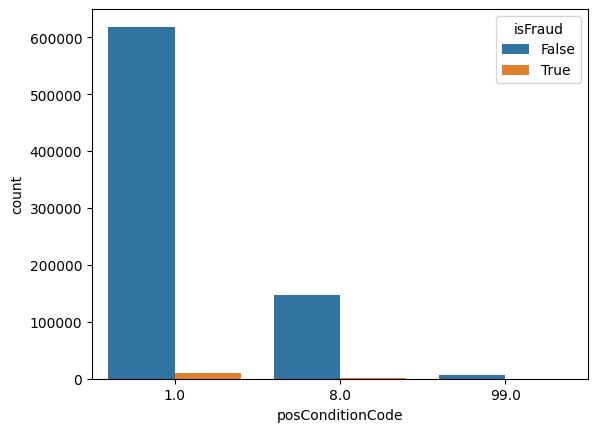

In [13]:
sns.countplot(data=df, x='posConditionCode', hue='isFraud')

<AxesSubplot:xlabel='merchantCategoryCode', ylabel='count'>

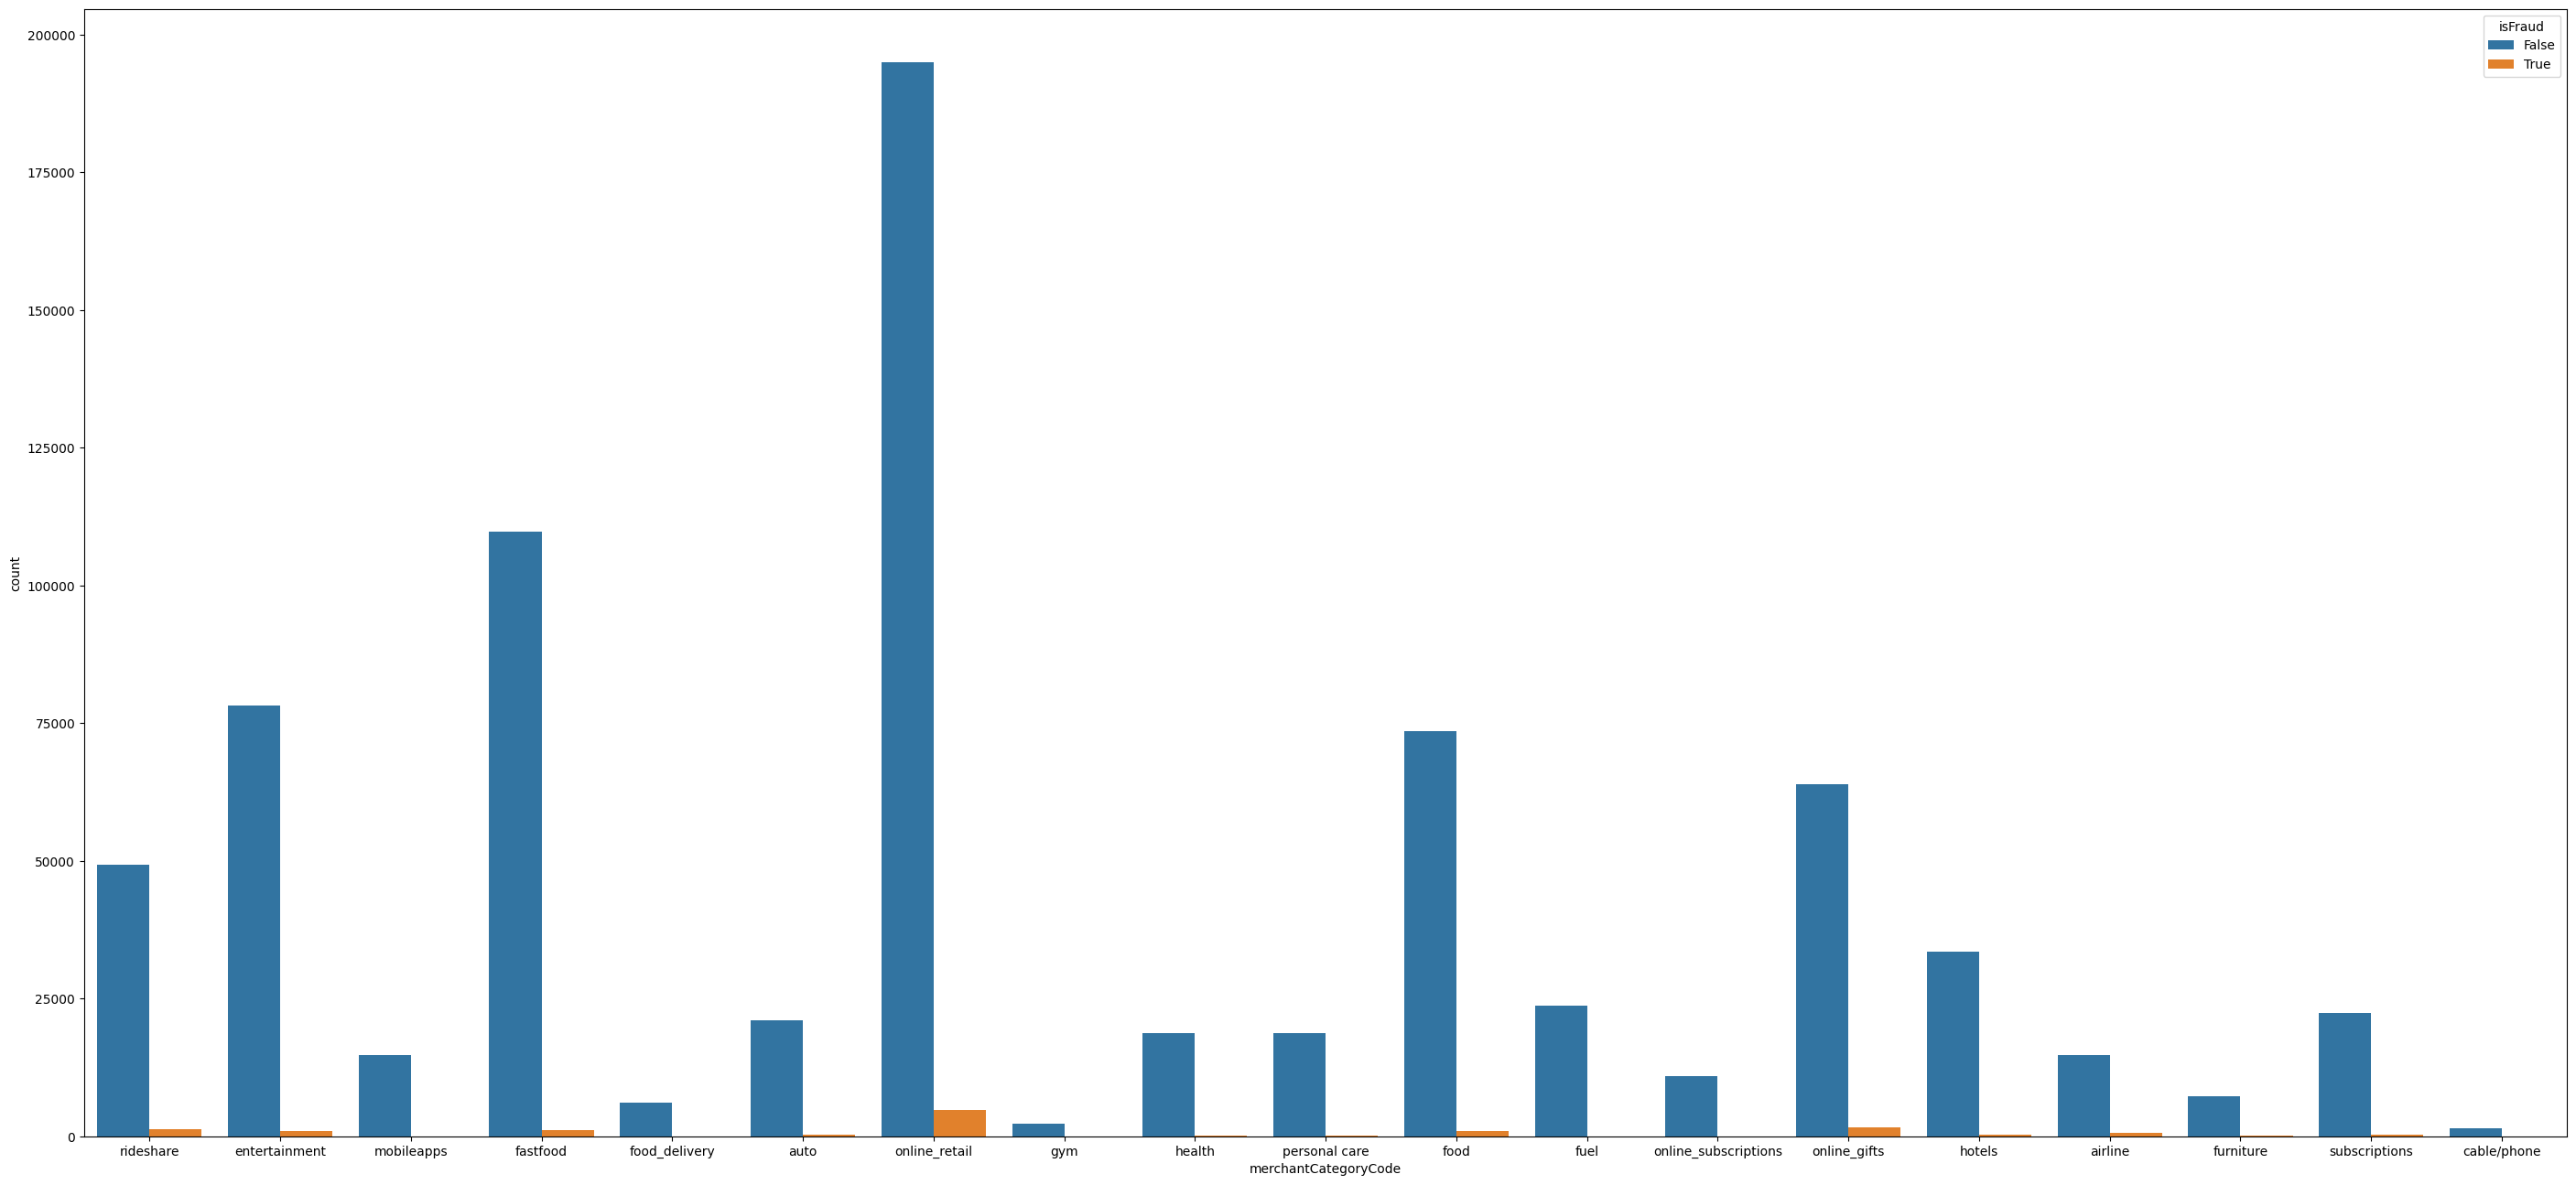

In [14]:
plt.figure(figsize=(35,16))
sns.countplot(data=df_ml, x='merchantCategoryCode', hue='isFraud')

<AxesSubplot:xlabel='matchingCVV', ylabel='count'>

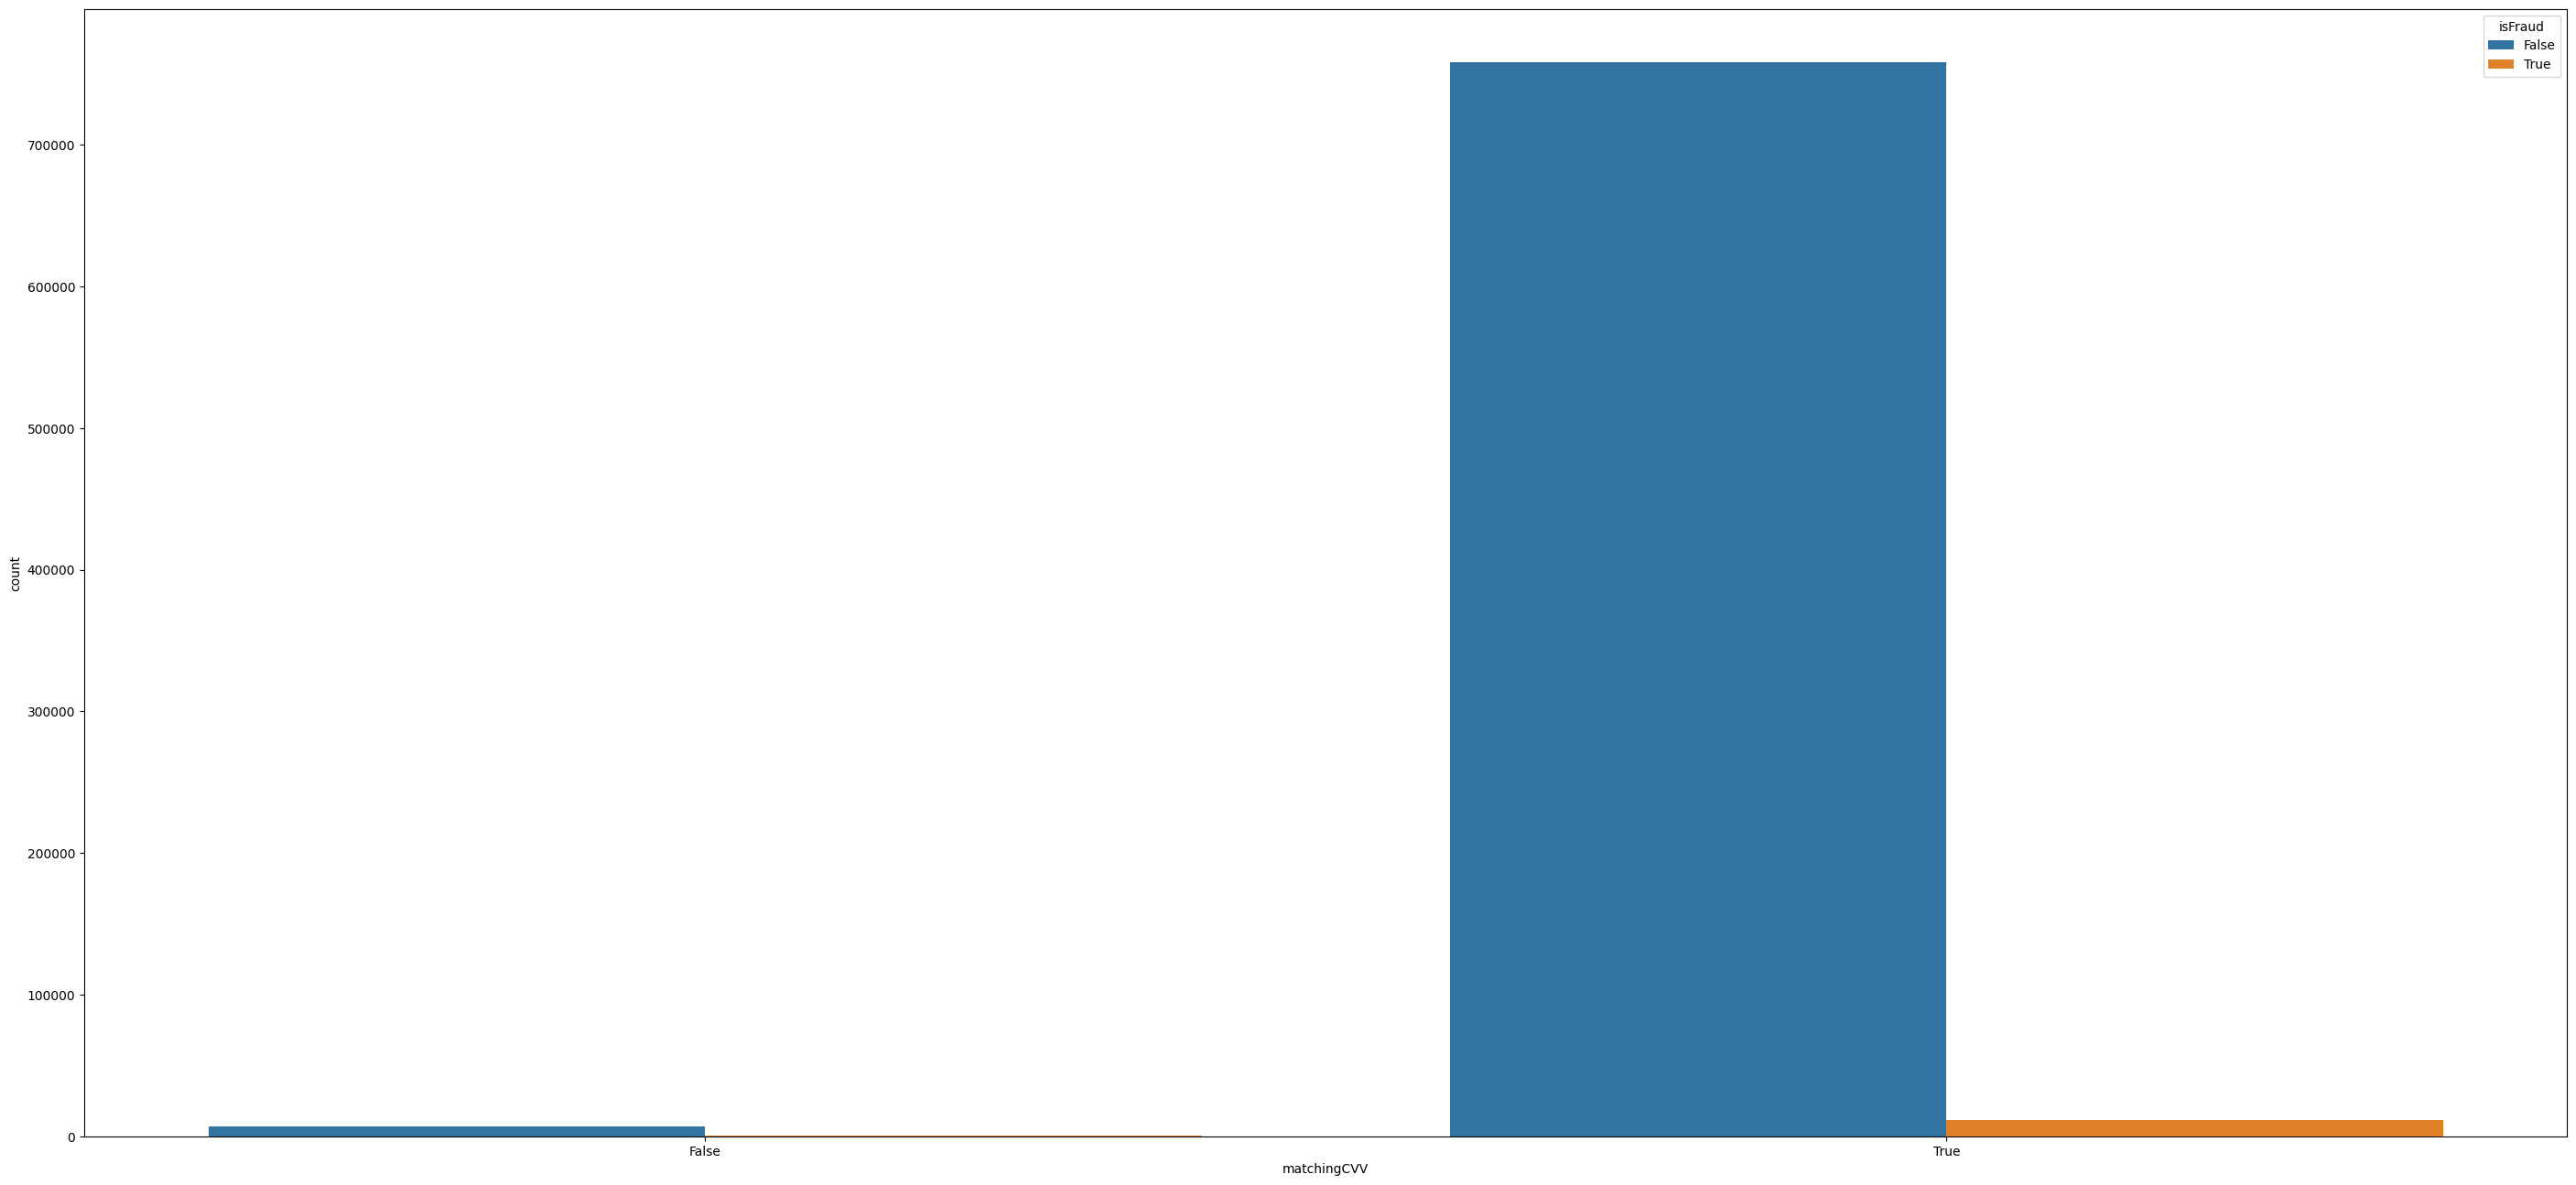

In [15]:
plt.figure(figsize=(35,16))
sns.countplot(data=df_ml, x='matchingCVV', hue='isFraud')

<AxesSubplot:xlabel='cardPresent', ylabel='count'>

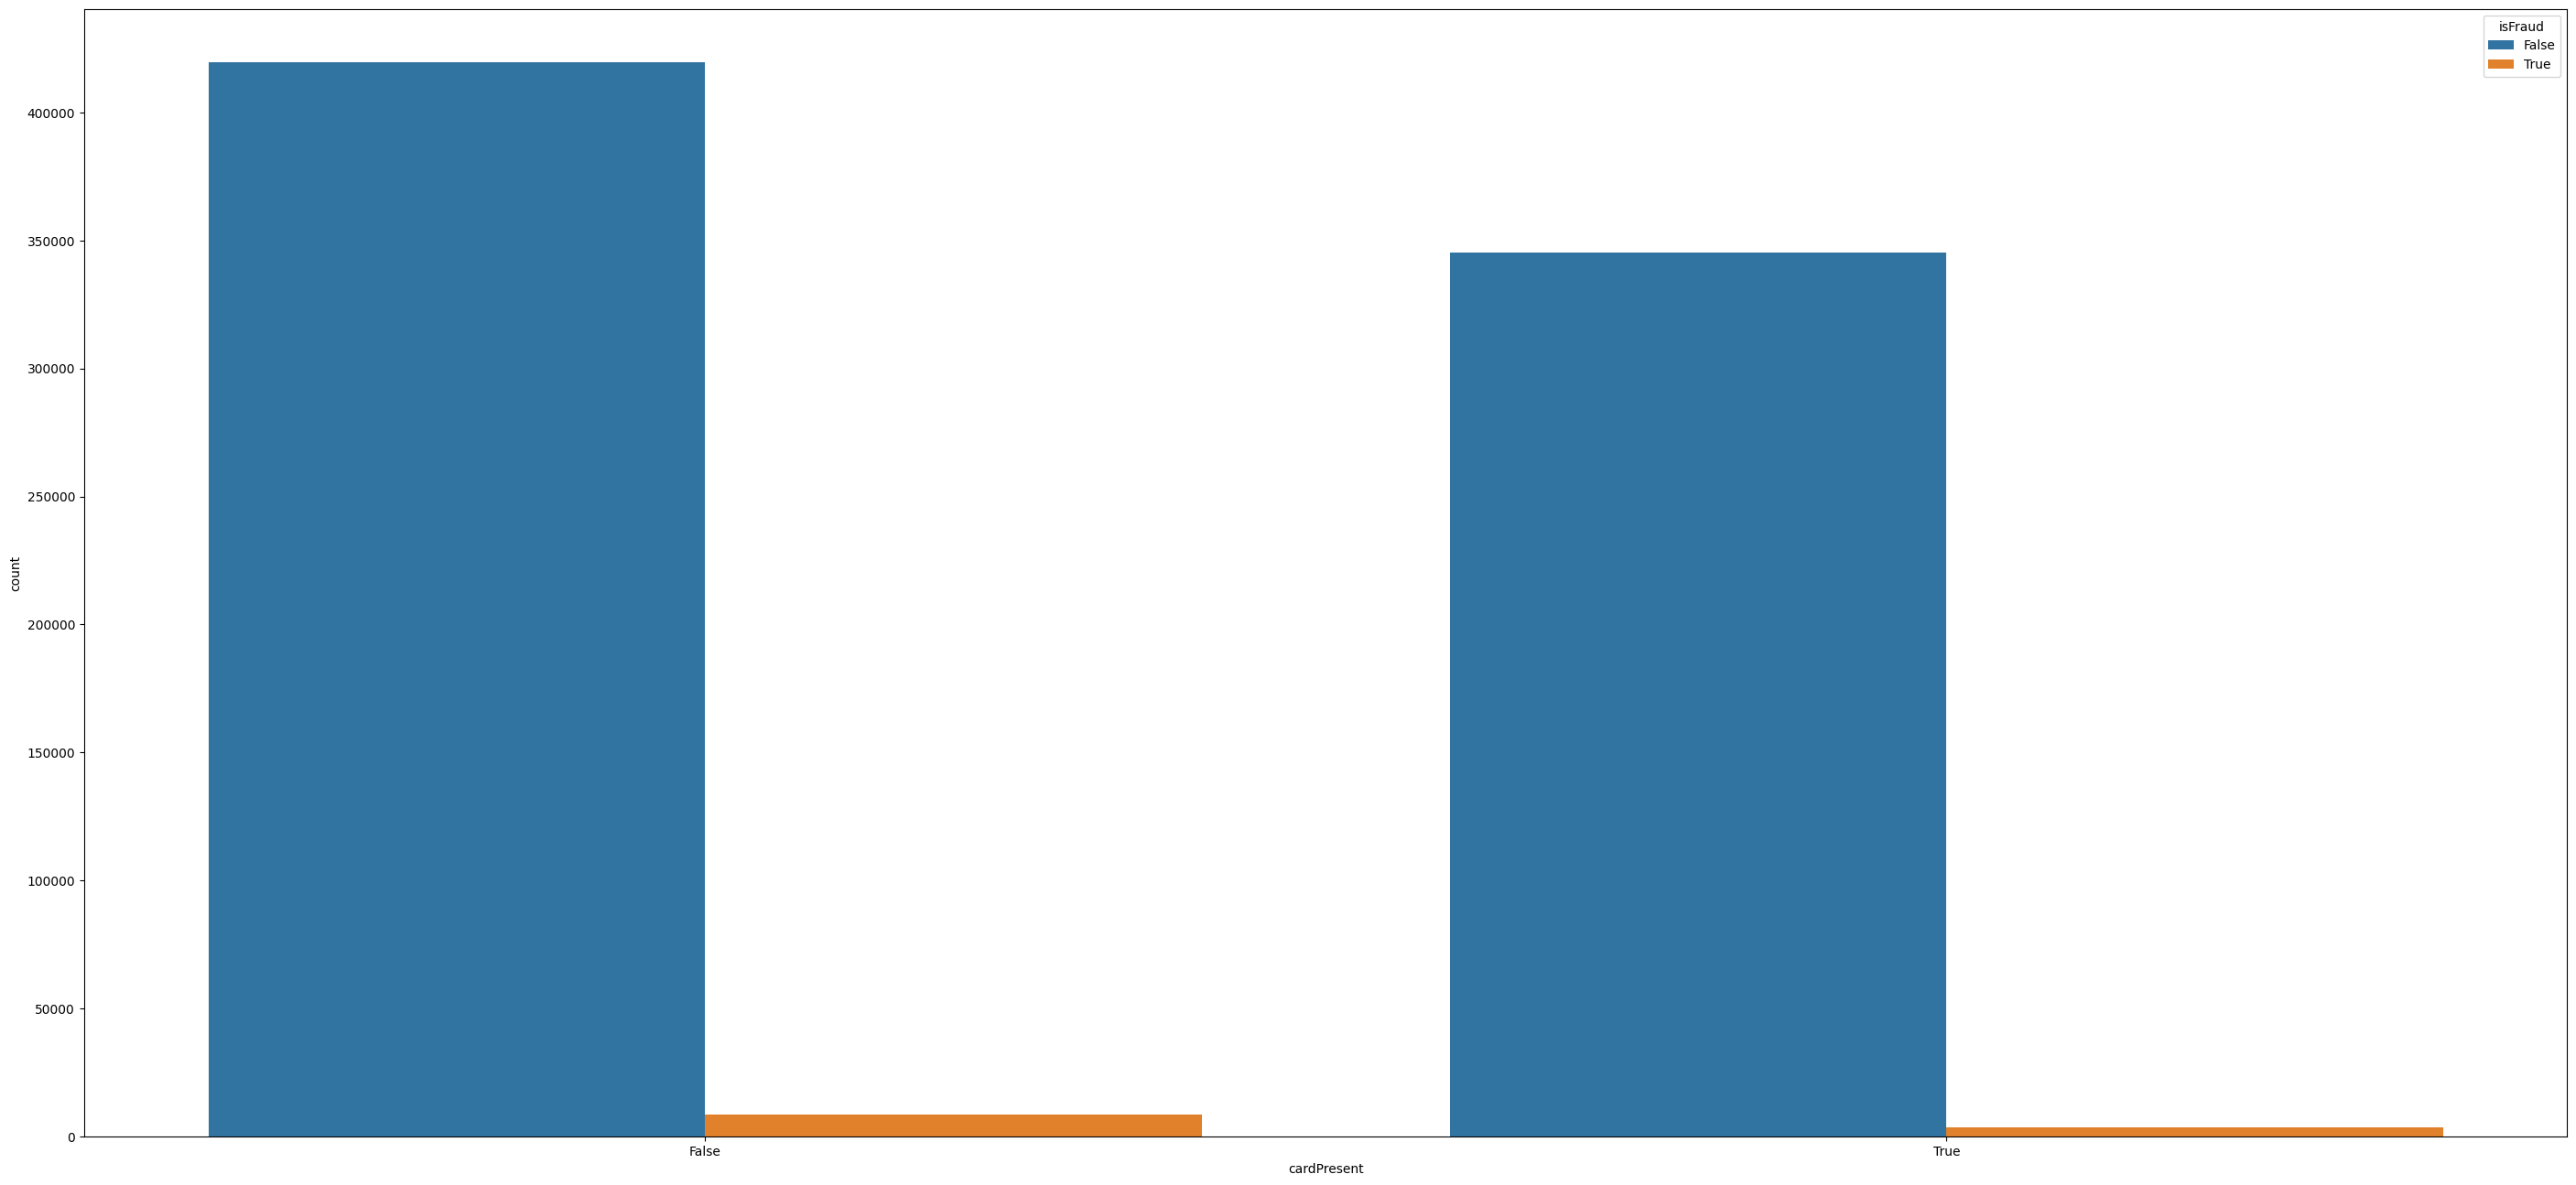

In [16]:
plt.figure(figsize=(35,16))
sns.countplot(data=df_ml, x='cardPresent', hue='isFraud')

Not much of correlation - Overall we can send it in not much of correlation and doesn't show much collinearity as well

#### Assumption #3: The Response Variable is Binary
Converting

In [17]:
for col in ['cardPresent', 'matchingCVV', 'expirationDateKeyInMatch', 'isFraud','cardPresent']:
    df_ml[col] = df_ml[col].replace({False: 0, True: 1})

In [18]:
def encode_and_bind(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    res = pd.concat([original_dataframe, dummies], axis=1)
    res = res.drop([feature_to_encode], axis=1)
    return(res) 

features_to_encode = ['merchantCountryCode', 'acqCountry','transactionType','merchantCategoryCode']
for feature in features_to_encode:
    df_ml = encode_and_bind(df_ml, feature)

In [19]:
df_ml.columns

Index(['creditLimit', 'availableMoney', 'transactionAmount', 'posEntryMode',
       'posConditionCode', 'currentBalance', 'cardPresent',
       'expirationDateKeyInMatch', 'isFraud', 'matchingCVV',
       'merchantCountryCode_CAN', 'merchantCountryCode_MEX',
       'merchantCountryCode_PR', 'merchantCountryCode_US', 'acqCountry_CAN',
       'acqCountry_MEX', 'acqCountry_PR', 'acqCountry_US',
       'transactionType_ADDRESS_VERIFICATION', 'transactionType_PURCHASE',
       'transactionType_REVERSAL', 'merchantCategoryCode_airline',
       'merchantCategoryCode_auto', 'merchantCategoryCode_cable/phone',
       'merchantCategoryCode_entertainment', 'merchantCategoryCode_fastfood',
       'merchantCategoryCode_food', 'merchantCategoryCode_food_delivery',
       'merchantCategoryCode_fuel', 'merchantCategoryCode_furniture',
       'merchantCategoryCode_gym', 'merchantCategoryCode_health',
       'merchantCategoryCode_hotels', 'merchantCategoryCode_mobileapps',
       'merchantCategoryCode_o

#### Assumption #4: The Sample Size is Sufficiently Large
Sample size is quite large but also biased - Have to do some pre processing

#### Assumption #5: There are No Extreme Outliers
There are outliers but lets see how susceptible it is towards the model

Please build a predictive model to determine whether a given transaction will be fraudulent or not. Use as much of the data as you like (or all of it).

In [20]:
print("TRAIN TEST SPLIT")

X = df_ml.loc[:, df_ml.columns != "isFraud"]
y = df_ml["isFraud"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

print("Dataset",df_ml["isFraud"].value_counts())
print("Train", np.unique(y_train,return_counts = True))
print("Test", np.unique(y_test,return_counts = True))

print(df_ml.dtypes)
display(X)

TRAIN TEST SPLIT
Dataset 0    764702
1     11966
Name: isFraud, dtype: int64
Train (array([0, 1]), array([611806,   9528]))
Test (array([0, 1]), array([152896,   2438]))
creditLimit                                    int64
availableMoney                               float64
transactionAmount                            float64
posEntryMode                                 float64
posConditionCode                             float64
currentBalance                               float64
cardPresent                                    int64
expirationDateKeyInMatch                       int64
isFraud                                        int64
matchingCVV                                    int64
merchantCountryCode_CAN                        uint8
merchantCountryCode_MEX                        uint8
merchantCountryCode_PR                         uint8
merchantCountryCode_US                         uint8
acqCountry_CAN                                 uint8
acqCountry_MEX                     

,creditLimit,availableMoney,transactionAmount,posEntryMode,posConditionCode,currentBalance,cardPresent,expirationDateKeyInMatch,matchingCVV,merchantCountryCode_CAN,...,merchantCategoryCode_gym,merchantCategoryCode_health,merchantCategoryCode_hotels,merchantCategoryCode_mobileapps,merchantCategoryCode_online_gifts,merchantCategoryCode_online_retail,merchantCategoryCode_online_subscriptions,merchantCategoryCode_personal care,merchantCategoryCode_rideshare,merchantCategoryCode_subscriptions
0,5000,5000.00,98.55,2.0,1.0,0.00,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
1,5000,5000.00,74.51,9.0,1.0,0.00,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,5000,5000.00,7.47,9.0,1.0,0.00,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
3,5000,5000.00,7.47,9.0,1.0,0.00,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
4,5000,5000.00,71.18,2.0,1.0,0.00,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786358,50000,48904.96,119.92,90.0,1.0,1095.04,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
786359,50000,48785.04,18.89,9.0,1.0,1214.96,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
786360,50000,48766.15,49.43,2.0,1.0,1233.85,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
786361,50000,48716.72,49.89,9.0,99.0,1283.28,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0


isFraud is highly skewed towards False so there is a good chance it might not learn True(s) clearly
But lets continue and see then we can try

Other Approaches
Under-sampling: Remove samples from over-represented classes ; use this if you have huge dataset
Over-sampling: Add more samples from under-represented classes; use this if you have small dataset
SMOTE (Synthetic Minority Over-sampling Technique)

Dataset : 776668

False    764702
True     11966

Train : 

False   1611806
True    9528

Test : 

False   152896
True   2438


### Logistic Regression

In [ ]:
lrt_biased = LogisticRegression(penalty='elasticnet',l1_ratio=0.2,max_iter=500,random_state=0,solver='saga').fit(X_train, y_train)

/Users/yamini/Library/Python/3.8/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [ ]:
Y_predicted = lrt_biased.predict(X_test)

unique, counts = np.unique(Y_predicted, return_counts=True)
print(unique, counts)

print("Accuracy of the model is",float(lrt_biased.score(X_test, y_test)))

[0] [155334]
Accuracy of the model is 0.9843047883914662


### Inference
Since the data is completely inclined towards no of False class, this logistic regression hasn't learnt anything to understand True Fraud Transaction
This Logistic regression is the base model that predicts a constant value irrespective of the transaction
Have to downsample

### Approach 1 : Under Sampling

In [ ]:
ros = RandomUnderSampler()
y = df_ml['isFraud']
df_ml.drop('isFraud', inplace=True, axis=1)
new_x, new_y = ros.fit_resample(df_ml, y)
print(f'Before Random Under Sampling: {df_ml.shape}')
print(f'After Random Under Sampling: {new_x.shape}')

Before Random Under Sampling: (776668, 39)
After Random Under Sampling: (23932, 39)


In [ ]:
x_train_unbiased, x_test_unbiased, y_train_unbiased, y_test_unbiased = train_test_split(new_x, new_y)


### Logitic Regression


In [ ]:
print(np.unique(new_y,return_counts = True))

(array([0, 1]), array([11966, 11966]))


In [ ]:
lrt_unbiased = LogisticRegression(penalty='elasticnet',l1_ratio=0.2,max_iter=1000,multi_class = 'multinomial',random_state=0,solver='saga').fit(x_train_unbiased, y_train_unbiased)
y_test_predicted = lrt_unbiased.predict(x_test_unbiased)
print("Accuracy of the model is",float(lrt_unbiased.score(x_test_unbiased, y_test_unbiased)))
unique, counts = np.unique(y_test_predicted, return_counts=True)
print(unique, counts)

Accuracy of the model is 0.584656526826007
[0 1] [1907 4076]


/Users/yamini/Library/Python/3.8/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


#### Reason for params
I dint want more ratio in l1_ratio because I don't want to do a lot of feature selection as we have enough not too many to remove few of the features
l1 regularisation will make the coefficient go to 0 unlike l2 that will normalise it so I used elastic net
Saga as I am using ‘multi_class’ set to ‘multinomial’

#### Experimenting

/Users/yamini/Library/Python/3.8/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yamini/Library/Python/3.8/lib/python/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


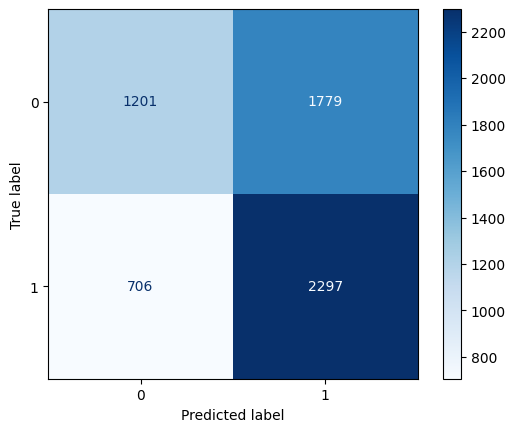

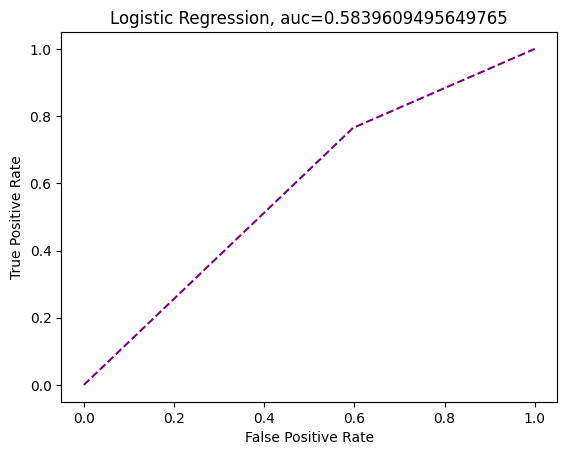

[0 1] [1907 4076]
Accuracy of the model is 0.584656526826007


In [ ]:
# Training
lrt_unbiased_model_2 = LogisticRegression(penalty='elasticnet',C=500,l1_ratio=0.2,max_iter=1000,multi_class = 'multinomial',random_state=0,solver='saga').fit(x_train_unbiased, y_train_unbiased)

#Inference
y_test_predicted = lrt_unbiased_model_2.predict(x_test_unbiased)


# Metrics
confusion_matrix(lrt_unbiased_model_2, x_test_unbiased, y_test_unbiased)
plt.show()
fpr_lr,tpr_lr,auc_lr = roc_auc_curve(y_test_unbiased,y_test_predicted,"Logistic Regression",'purple')
lr_metrics = [fpr_lr,tpr_lr,auc_lr]

unique, counts = np.unique(y_test_predicted, return_counts=True)
print(unique, counts)

acc_lr = float(lrt_unbiased_model_2.score(x_test_unbiased, y_test_unbiased))
print("Accuracy of the model is",acc_lr)

model_metrics["Model_name"].append("Logistic Regression")
model_metrics["TPR"].append(tpr_lr)
model_metrics["FPR"].append(fpr_lr)
model_metrics["AUC Score"].append(auc_lr)
model_metrics["Accuracy"].append(acc_lr)

In [ ]:
#### Features that Logistic regression found useful

### Decision Tree

Advantages:
- It can capture nonlinear relationships: They can be used to classify non-linearly separable data. - Here since we don't know the exact relationship might be useful
- Decision tree is non-parametric: Non-Parametric method is defined as the method in which there are no assumptions about the spatial distribution and the classifier structure.

Diadvantages:
1. A small change in the data can cause a large change in the structure of the decision tree causing instability. - Since we undersampled not sure if it is the best models
2. Decision tree training is relatively expensive as the complexity and time has taken are more.
3. It can’t be used in big data: If the size of data is too big, then one single tree may grow a lot of nodes which might result in complexity and leads to overfitting. - In our case we have lot of features there is a possibility of this

/Users/yamini/Library/Python/3.8/lib/python/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


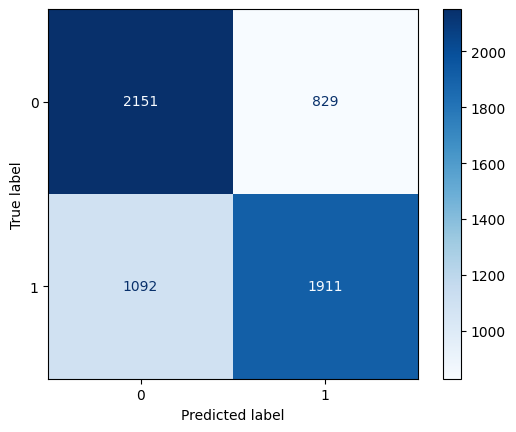

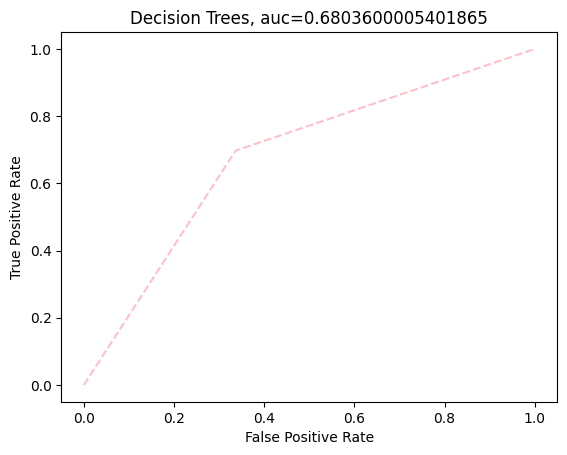

Accuracy of the model is 0.6789236169145914


In [ ]:
dtc = DecisionTreeClassifier(max_depth=7,min_samples_leaf=7, random_state=0)

# Training
dtc.fit(x_train_unbiased, y_train_unbiased)

# Inference
y_pred = dtc.predict(x_test_unbiased)
y_pred_prob = dtc.predict_proba(x_test_unbiased)[:,1]

# Metrics
confusion_matrix(dtc, x_test_unbiased, y_test_unbiased)
plt.show()

fpr_dt,tpr_dt,auc_dt = roc_auc_curve(y_pred,y_test_unbiased,"Decision Trees",'pink')
dt_metrics = [fpr_dt,tpr_dt,auc_dt]

acc_dtc = float(dtc.score(x_test_unbiased, y_test_unbiased))
print("Accuracy of the model is",acc_dtc)

model_metrics["Model_name"].append("Decision Tree")
model_metrics["TPR"].append(tpr_dt)
model_metrics["FPR"].append(fpr_dt)
model_metrics["AUC Score"].append(auc_dt)
model_metrics["Accuracy"].append(acc_lr)

For Decision Tree Claasifier


<BarContainer object of 5 artists>

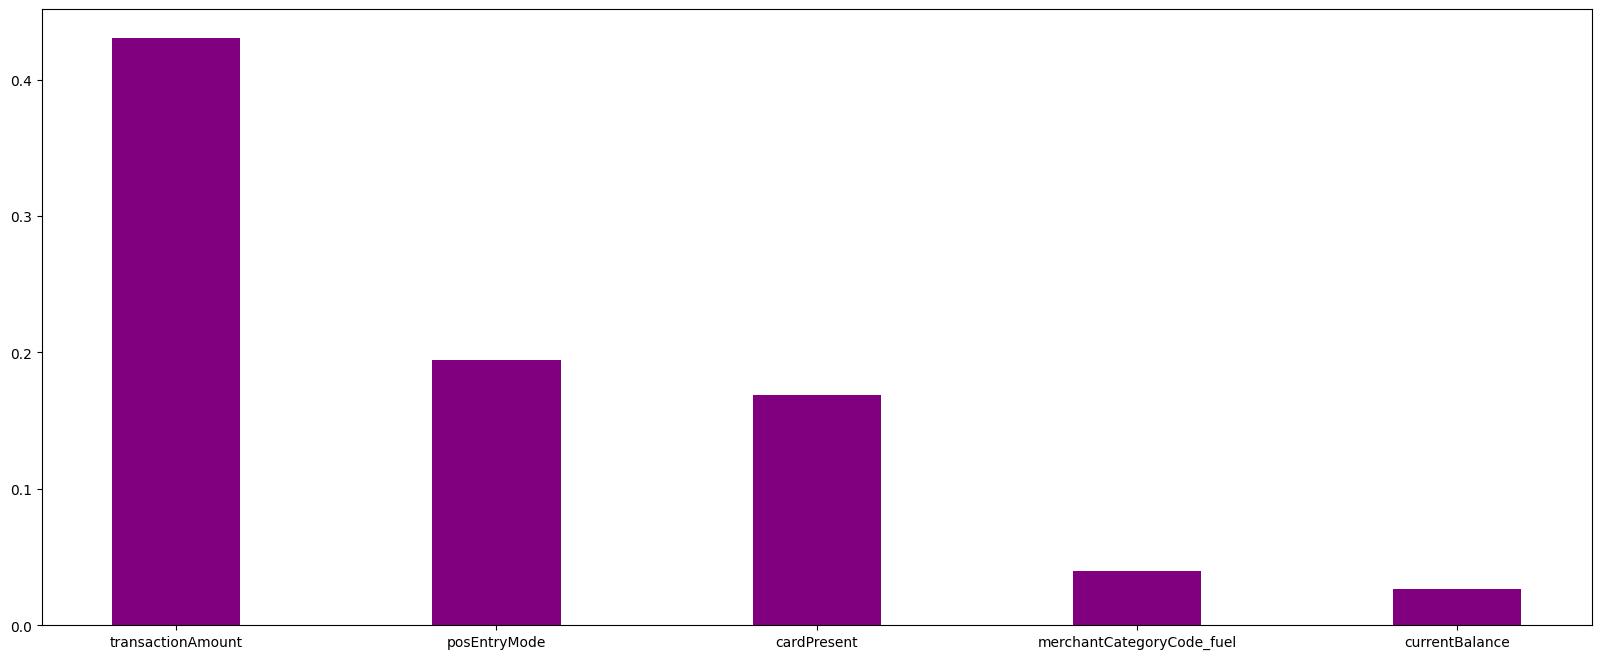

In [47]:
print("For Decision Tree Claasifier")
feature_importance = {}
cnt_features = 0
for importance, name in sorted(zip(dtc.feature_importances_, X_train),reverse=True):
    cnt_features +=1
    feature_importance[name]=importance
    if cnt_features ==5:
        break
    
plt.figure(figsize=(20,8))
plt.bar(feature_importance.keys(), feature_importance.values(), color ='purple', width = 0.4)

#### Random forest

Advantages:
- Random Forest is based on the bagging algorithm and uses Ensemble Learning technique. It creates as many trees on the subset of the data and combines the output of all the trees. In this way it reduces overfitting problem in decision trees and also reduces the variance and therefore improves the accuracy.
- Handles non-linear parameters efficiently: Non linear parameters don't affect the performance of a Random Forest unlike curve based algorithms. So, if there is high non-linearity between the independent variables, Random Forest may outperform as compared to other curve based algorithms. 
- Random Forest is usually robust to outliers and can handle them automatically. 


Disadvantages:
- Random Forest creates a lot of trees (unlike only one tree in case of decision tree) and combines their outputs. By default, it creates 100 trees in Python sklearn library. To do so, this algorithm requires much more computational power and resources. On the other hand decision tree is simple and does not require so much computational resources.


/Users/yamini/Library/Python/3.8/lib/python/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


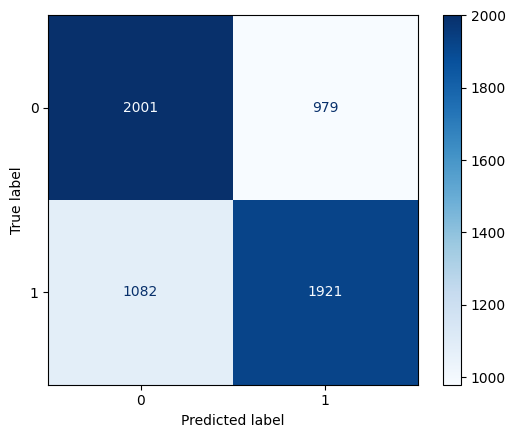

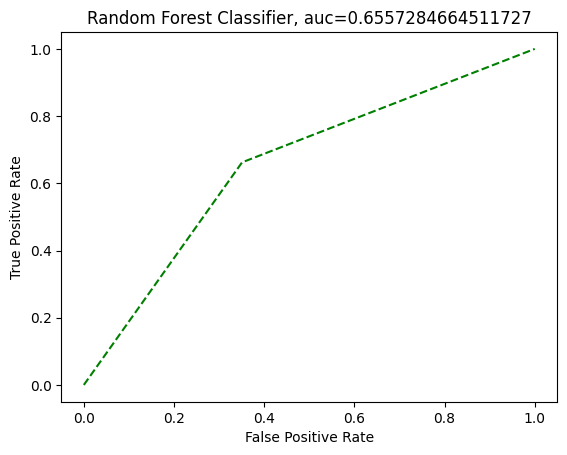

Accuracy of the model is 0.6555239846230988


In [ ]:
rfc = RandomForestClassifier(max_depth = 5, bootstrap= True,min_samples_split= 5,min_samples_leaf= 2, max_features= 'sqrt', oob_score= True)

# Training
rfc.fit(x_train_unbiased, y_train_unbiased)

# Inference
y_pred = rfc.predict(x_test_unbiased)
y_pred_prob = rfc.predict_proba(x_test_unbiased)[:,1]

# Metrics
confusion_matrix(rfc, x_test_unbiased, y_test_unbiased)
plt.show()

fpr_rfc,tpr_rfc,auc_rfc = roc_auc_curve(y_pred,y_test_unbiased,"Random Forest Classifier",'green')
rf_metrics = [fpr_rfc,tpr_rfc,auc_rfc ]

acc_rfc = float(rfc.score(x_test_unbiased, y_test_unbiased))
print("Accuracy of the model is",acc_rfc)

model_metrics["Model_name"].append("Random Forest Classifer")
model_metrics["TPR"].append(tpr_rfc)
model_metrics["FPR"].append(fpr_rfc)
model_metrics["AUC Score"].append(auc_rfc)
model_metrics["Accuracy"].append(acc_rfc)

### XGBoost

Parallelization: The model is implemented to train with multiple CPU cores.
Regularization: XGBoost includes different regularization penalties to avoid overfitting. Penalty regularizations produce successful training so the model can generalize adequately.
Non-linearity: XGBoost can detect and learn from non-linear data patterns.
Cross-validation: Built-in and comes out-of-the-box.


Advantages:
- It works well on small data, data with subgroups, big data, and complicated data. 
- It tends to do better than most supervised learning algorithms on those types of data problems.
    
Disadvantages:
- It doesn’t work so well on sparse data, though, and very dispersed data can create some issues, as well. 

/Users/yamini/Library/Python/3.8/lib/python/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


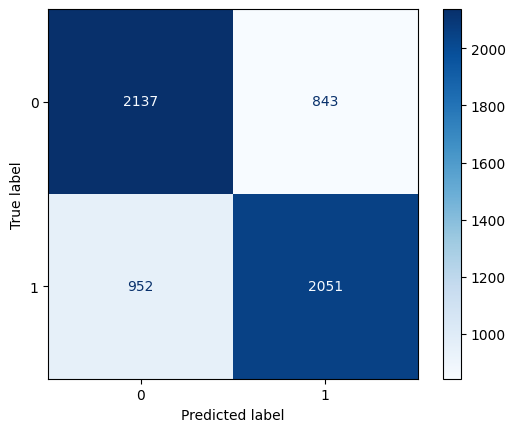

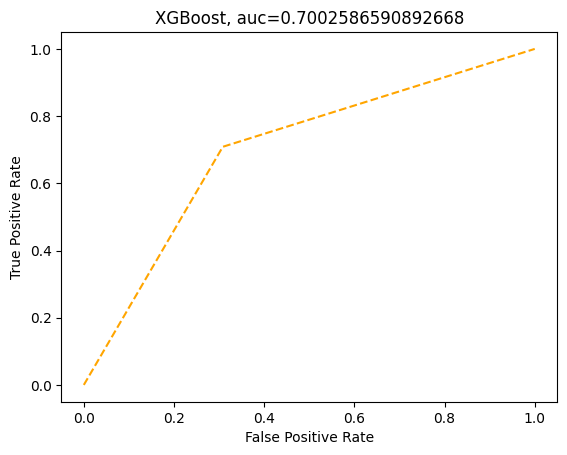

Accuracy of the model is 0.6999832859769346


In [ ]:
xgb_model = xgb.XGBClassifier(learning_rate= 0.1, max_depth= 5,n_estimators= 125,n_jobs= -1,reg_alpha= 0.5,reg_lambda= 0.5)

# Training
xgb_model.fit(x_train_unbiased, y_train_unbiased)

# Inference
y_pred = xgb_model.predict(x_test_unbiased)

# Metrics
confusion_matrix(xgb_model, x_test_unbiased, y_test_unbiased)
plt.show()

fpr_xgb,tpr_xgb,auc_xgb = roc_auc_curve(y_pred,y_test_unbiased,"XGBoost",'orange')
xgb_metrics = [fpr_xgb,tpr_xgb,auc_xgb]

acc_xgb = float(xgb_model.score(x_test_unbiased, y_test_unbiased))
print("Accuracy of the model is",acc_xgb)

model_metrics["Model_name"].append("XG Boost")
model_metrics["TPR"].append(tpr_xgb)
model_metrics["FPR"].append(fpr_xgb)
model_metrics["AUC Score"].append(auc_xgb)
model_metrics["Accuracy"].append(acc_xgb)

### Ada Boost
First-round classifiers (learners) are all trained using weighted coefficients that are equal,
In subsequent boosting rounds the adaptive process increasingly weighs data points that were misclassified by the learners in previous rounds and decrease the weights for correctly classified ones. 
Wanted to experiment with other similar to XGBoost Classifier

/Users/yamini/Library/Python/3.8/lib/python/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


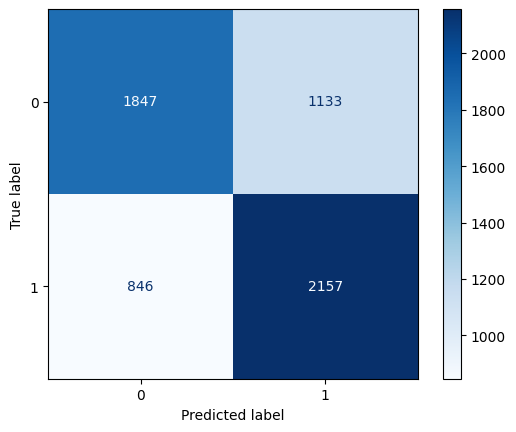

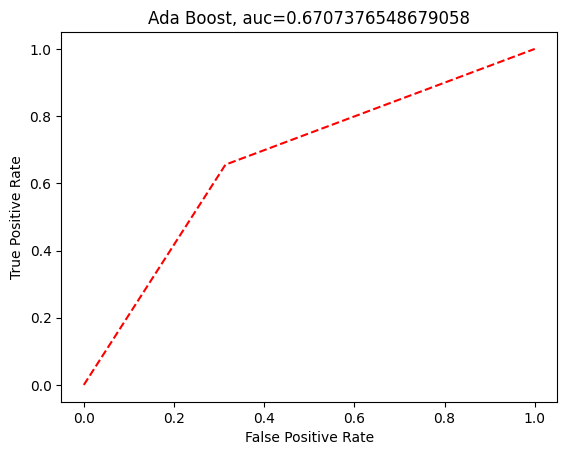

Accuracy of the model is 0.6692294835366873


In [ ]:
abc = AdaBoostClassifier(learning_rate= 0.1, n_estimators= 125,random_state=0)
abc.fit(x_train_unbiased, y_train_unbiased)

# Inference
y_pred = abc.predict(x_test_unbiased)

# Metrics
confusion_matrix(abc, x_test_unbiased, y_test_unbiased)
plt.show()

fpr_abc,tpr_abc,auc_abc = roc_auc_curve(y_pred,y_test_unbiased,"Ada Boost",'red')
abc_metrics = [fpr_abc,tpr_abc,auc_abc]

acc_abc = float(abc.score(x_test_unbiased, y_test_unbiased))
print("Accuracy of the model is",acc_abc)

model_metrics["Model_name"].append("Ada Boost Classifier")
model_metrics["TPR"].append(tpr_abc)
model_metrics["FPR"].append(fpr_abc)
model_metrics["AUC Score"].append(auc_abc)
model_metrics["Accuracy"].append(acc_abc)

### Metrics

Provide an estimate of performance using an appropriate sample, and show your work.

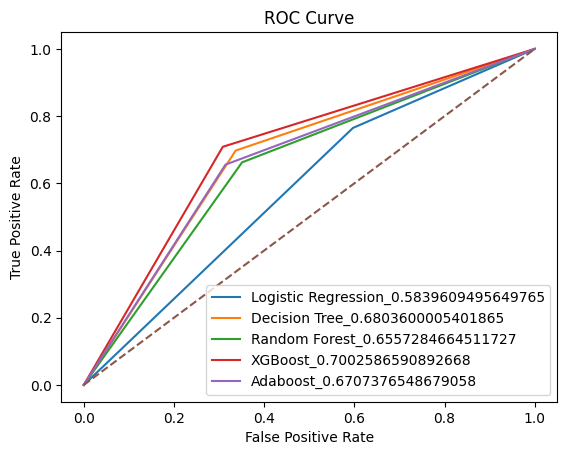

In [ ]:
model = {
    'Logistic Regression': lr_metrics,
    'Decision Tree': dt_metrics,
    'Random Forest': rf_metrics,
    'XGBoost': xgb_metrics,
    'Adaboost':abc_metrics
}
plot_roc(model)

In [ ]:
df_metrics = pd.DataFrame.from_dict(model_metrics)
display(df_metrics)

,Model_name,FPR,TPR,Accuracy,AUC Score
0,Logistic Regression,"[0.0, 0.5969798657718121, 1.0]","[0.0, 0.7649017649017649, 1.0]",0.584657,0.583961
1,Decision Tree,"[0.0, 0.3367252543940796, 1.0]","[0.0, 0.6974452554744526, 1.0]",0.584657,0.680360
2,Random Forest Classifer,"[0.0, 0.35095686020110284, 1.0]","[0.0, 0.6624137931034483, 1.0]",0.655524,0.655728
3,XG Boost,"[0.0, 0.30819035286500485, 1.0]","[0.0, 0.7087076710435384, 1.0]",0.699983,0.700259
4,Ada Boost Classifier,"[0.0, 0.31414779056813963, 1.0]","[0.0, 0.6556231003039513, 1.0]",0.669229,0.670738


For XGB Claasifier


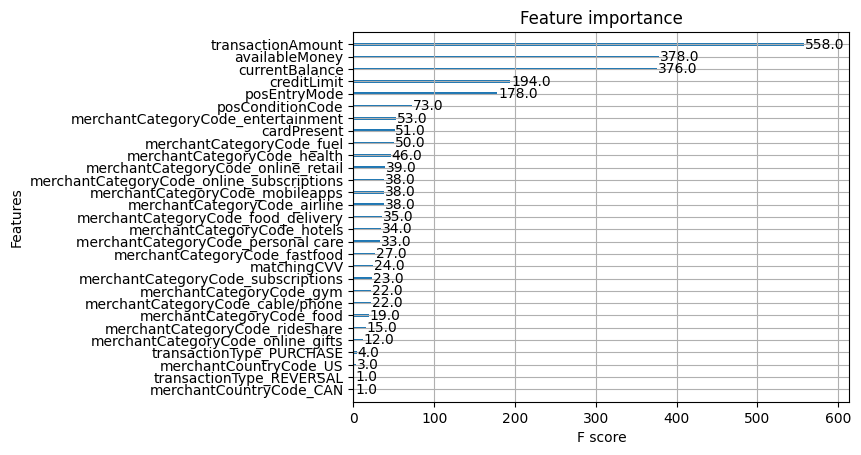

In [39]:
print("For XGB Claasifier")
plot_importance(xgb_model)
plt.show()

### Observations:
1. Highly Biased data and under sampling means loss of datadaboost which shows boosting is helping
2. XG Boost best performing model followed by Ada Boost so which means Boosting is helping in this kind of data
3. Since I did not try cross validation and have a validation set out can't really comment on overfitting and underfitting but since its random and I did try it for multiple iterations and the accuracy did not have much difference. So is not over or underfitting
4. Common features that are helpful in detecting Fraud is Transaction Amount, Current Balance, Available Balance, CreditLimit

####  Couple Of things I want to try
- Under sampled data - May be experiment there a little more
- NaN(s) removed - can try imputation
- Val set - Cross Validation
- Try understanding the probabilities and checking for different thresholds(AUC ROC Curve)
- Also plot AUC ROC curve one class against the other
- Try different other models like SVM
- Also give chance to unsupervised learning like clustering techniques
- I also removed few columns like date and time from features which I would like to include while further investigating
- Ensembling methods like use the results from all models and consolidate it

#### Tried 
- I ran GridCV for the models to experiement with various params and decide - did not run it again here as it takes lot of time, 
You can find the code below though
- Chose Models based on intution and made changes to parameters - reasons specified above

'''

params = { 'penalty': ['l2', 'none'], 'C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 10, 100], 'fit_intercept': [True, False], 'n_jobs': [-1] }
grid = GridSearchCV(estimator=LogisticRegression(max_iter=1000), param_grid=params, cv=5, verbose=3)
grid.fit(x_train_unbiased, y_train_unbiased)


params = { 'penalty': ['l2', 'none'], 'C': [100,200,500,800,1000], 'fit_intercept': [True, False], 'n_jobs': [-1] }
grid_c_change = GridSearchCV(estimator=LogisticRegression(max_iter=1000), param_grid=params, cv=5, verbose=3)
grid_c_change.fit(x_train_unbiased, y_train_unbiased)

'''